<a id="topF"></a>

# Filtering out COS Data taken during the Day or Night

# Learning Goals
### This Notebook is designed to walk the user (*you*) through: **Filtering Cosmic Origins Spectrograph (*COS*) `TIME-TAG` data taken during the day from data taken during the night**:
   #### 1. [**Processing a spectrum from a filtered dataset**](#procF)
   ##### - 1.1. [Filtering the `TIME-TAG` data](#filtF)
   ##### - 1.2. [Creating a new association file](#asnF)
   ##### - 1.3. [Running the `calcos` pipeline on the filtered dataset](#calcosF)
   #### 2. [**Comparing the filtered and unfiltered data**](#compF)

# 0. Introduction and Setup
#### The Cosmic Origins Spectrograph ([*COS*](https://www.nasa.gov/content/hubble-space-telescope-cosmic-origins-spectrograph)) is an ultraviolet spectrograph on-board the Hubble Space Telescope([*HST*](https://www.stsci.edu/hst/about)) with capabilities in the near ultraviolet (*NUV*) and far ultraviolet (*FUV*). 

#### This tutorial aims to prepare you to work with the COS data of your choice by walking you through filtering `TIME-TAG` datapoints obtained by COS. 

In particular, this tutorial will walk you through separating datapoints obtained during the Hubble Space Telescope's "night" - when the sun is below the geometric horizon from the observatory's point of view - from datapoints taken during the observatory's "day" - when the sun is above this horizon. 
You may wish to segregate photons from these two time periods, as data taken during the day can be subject to different and higher background noise conditions, as well as more intense geocoronal Lyman-alpha or Oxygen-I emission lines from the Earth’s atmosphere ([See Data Handbook 5.4.2](https://hst-docs.stsci.edu/cosdhb/chapter-5-cos-data-analysis/5-4-working-with-time-tag-data#id-5.4WorkingwithTIME-TAGData-5.4.2FilteringTime-TagData)).
This type of data separation is possible with the [`TIME-TAG` data](https://hst-docs.stsci.edu/cosdhb/chapter-1-cos-overview/1-1-instrument-capabilities-and-design) obtained by the COS photon-counting detectors, because each individual encounter with a photon is recorded with its own metadata such as the time of the encounter, and the physical position of Hubble at that time.

- For an in-depth manual to working with COS data and a discussion of caveats and user tips, see the [COS Data Handbook](https://hst-docs.stsci.edu/display/COSDHB/).
- For a detailed overview of the COS instrument, see the [COS Instrument Handbook](https://hst-docs.stsci.edu/display/COSIHB/).

## We will import the following packages:

- costools timefilter to select `TIME-TAG` datapoints by their metadata parameters
- calcos to re-process the data
- numpy to handle array functions
- astropy.io fits and astropy.table Table for accessing FITS files
- glob and os for working with system files
- matplotlib.pyplot and gridspec for plotting data
- astroquery.mast Mast and Observations for finding and downloading data from the [MAST](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html) archive

These python packages, including `calcos` and `costools` are installed standard with the the STScI conda distribution. For more information, see our notebook tutorial on [setting up an environment](https://github.com/spacetelescope/COS-Notebooks/blob/master/Setup/Setup.ipynb).

### A quick bug fix:
At present, there is a small bug in the calcos package which affects us when we try to import another package: `costools`. 

Before you can import in the cell below, you must alter a single line in the `x1d.py` file of your `calcos` package. 

- The only tricky part is *locating the package*. once you've activated your conda environment as discussed in the aforementioned notebook tutorial on [setting up an environment](https://github.com/spacetelescope/COS-Notebooks/blob/master/Setup/Setup.ipynb), you can find the python path with:

|Windows|Mac/Linux|
|-|-|
|`where python`|`which python`|

- This will probably return a path like: `/Users/<your username>/<miniconda3 or anaconda>/envs/<whatever you titled your environment, i.e. calcos_env>/bin/python`.

- The package file you need to edit will be close by, in a directory like: `/Users/<your username>/<miniconda3 or anaconda>/envs/<your_env>/lib/python3.6/site-packages/calcos/x1d.py`

- Open this file in the editor of your choice, i.e.: `vim /Users/<your username>/<miniconda3 or anaconda>/envs/<your_env>/lib/python3.6/site-packages/calcos/x1d.py`

- Comment out line \#19, which says: `from .version import *`, as this is the line which causes the bug.

- Save the file and now we can get to work!

In [1]:
# for filtering i.e. by sun altitude
from costools import timefilter
# for processing cos data
import calcos 
# for array manipulation
import numpy as np
# for reading fits files
from astropy.io import fits                                            
from astropy.table import Table
# for system files
import glob
import os
# for plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
# for downloading the data
from astroquery.mast import Observations

The following tasks in the costools package can be run with TEAL:
         splittag                 timefilter                 x1dcorr


## We will also define a few directories we will need:

In [2]:
data_dir = './data/'
intermediate_dir = './intermediate/'
output_dir = './output/'
plots_dir = output_dir + 'plots/'
# Make the directories in case they don't exist
!mkdir ./data
!mkdir ./intermediate
!mkdir ./output 
!mkdir ./output/plots/

mkdir: ./data: File exists
mkdir: ./intermediate: File exists
mkdir: ./output: File exists
mkdir: ./output/plots/: File exists


## And we will need to download the data we wish to filter and analyze
We choose the exposure with obs_id: `lbry01i6q`, because we happen to know it contains data taken both in the observatory's night and day and shows strong airglow lines. For more information on downloading COS data, see our [notebook tutorial on downloading COS data](https://github.com/spacetelescope/COS-Notebooks/blob/master/DataDL/DataDl.ipynb).

In [3]:
filename_root = 'lbry01i6q'

pl = Observations.get_product_list(Observations.query_criteria(proposal_id = '12604', obs_id = 'lbry01*')) # Get products list of all observations with that obs_id root
pl_mask = ((pl['productSubGroupDescription'] == "CORRTAG_A") | (pl['productSubGroupDescription'] == "CORRTAG_B")) & (pl['obs_id'] == filename_root) # create mask with only the corrtag files
Observations.download_products(pl[pl_mask], download_dir = './data') # Download those corrtag files

file_locations_orig = glob.glob('./**/*corrtag*.fits', recursive=True)
for file_orig in file_locations_orig:
    os.rename(file_orig, './data/'+os.path.basename(file_orig)) # grabs the data out of its long convoluted filepath
# NOTE - this is slightly dangerous if you may have any non-unique filenames - if you have lots of data, probably don't aggregate your data.

file_locations_a = glob.glob('./**/*corrtag_a.fits', recursive=True) # Finds all the FUVA raw files
file_locations_b = glob.glob('./**/*corrtag_b.fits', recursive=True) # Finds all the FUVB raw files

<a id = procF></a>
# 1. Processing a spectrum from a filtered dataset

<a id = filtF></a>
## 1.1. Filtering the `TIME-TAG` data
The `costools` package contains the `TimelineFilter` class, which - upon instantiation - filters by the parameters you give it. In other words, you don't have to run any functions or methods aside from instantiating the class. This is done by passing the following parameters to `timefilter.TimelineFilter`:
- input `time-tag` filepath (string)
- output `time-tag` filepath (string)
- filter (string)

##### Below, we will filter by the sun's altitude above the geometric horizon from the point-of-view of the Hubble Observatory. **Daytime** is whenever this altitude is greater than 0 degrees.

More filtering parameters can be found in the [Section 5.4.2 of the COS Data Handbook: Filtering Time-Tag Data](https://hst-docs.stsci.edu/cosdhb/chapter-5-cos-data-analysis/5-4-working-with-time-tag-data). 

*Some, but not all, of the available filters are*:
- time
- observatory latitude/longitude
- dark current rate
- any combination of filters

In [7]:
for afile, bfile in zip(file_locations_a,file_locations_b): # This must be repeated for all exposure files, so loop through both FUVA and FUVB
    timefilter.TimelineFilter(input=afile, output=intermediate_dir+"filtered_corrtag_a.fits", # Run TimelineFilter on FUVA file
                              filter = "sun_alt > 0.", verbose=True) # gets rid of Daytime data, i.e. where the sun's altitude above the horizon is 0 degrees
    timefilter.TimelineFilter(bfile, intermediate_dir+"filtered_corrtag_b.fits", # Run TimelineFilter on FUVB file
                                  "sun_alt > 0.")

Input file /Users/nkerman/Projects/COS-Notebooks/DayNight/data/lbry01i6q_corrtag_a.fits
sun_alt > 0. flagged as bad
EXPTIME changed from 1176.192 to 137.18394
New GTI extension appended
Writing to /Users/nkerman/Projects/COS-Notebooks/DayNight/intermediate/filtered_corrtag_a.fits


<a id = asnF></a>
## 1.2. Creating a new association file
In order to run the `calcos` pipeline on your newly filtered data, an association (`asn`) file must be made, instructing the pipeline where to look for the filtered `TIME-TAG` data files. In the next cells, we build **two** new association files from scratch:
1. For these new **filtered** files
2. For the original **unfiltered** files, so that we can compare and see the effect of filtering. 

In [8]:
# FIRST, for the newly filtered-by-sun_alt files

# this properly assigns the type of exposure in a way that CalCOS will recognize
type_dict = {'WAVECAL' : 'EXP-AWAVE',
             'EXTERNAL/SCI' : 'EXP-FP'}

files = glob.glob(intermediate_dir+"*_corrtag_a.fits") # This finds all the corrtag (just FUVA) files you filtered above
# You only need the A segment in the ASN, and calcos will find the associated B segment data for you
# These file locations and names will be different depending on your output name 

for f in files:    
    # Adding the file details to the association table
    rootnames = [f]  # MEMNAME
    types = [type_dict[fits.getval(f, 'EXPTYPE')]] # MEMTYPE
    included = [True] # MEMPRSNT
    
    # Adding the ASN details to the end of the association table
    # the rootname needs to be the full name, not just the rootname
    asn_root = os.path.basename(f.split('corrtag')[0][:-1]) # removing the extra "_" at the end of this
    rootnames.append(asn_root.upper()) # MEMNAME
    types.append('PROD-FP') # MEMTYPE
    included.append(True) # MEMPRSNT
    
    # Putting together the fits table
    #   40 is the number of characters allowed in this field. If your rootname is longer than 40, 
    #     you will need to increase this
    c1 = fits.Column(name='MEMNAME', array=np.array(rootnames), format='40A') 
    c2 = fits.Column(name='MEMTYPE', array=np.array(types), format='14A')
    c3 = fits.Column(name='MEMPRSNT', format='L', array=included)
    t = fits.BinTableHDU.from_columns([c1, c2, c3])
    
    # Writing the fits table
    t.writeto(asn_root.lower()+'_asn.fits')

    print('Saved: {}'.format(asn_root.lower()+'_asn.fits' ), "in the cwd directory")

Saved: filtered_asn.fits in the cwd directory


We can see the contents of this association file below:

In [9]:
Table.read("filtered_asn.fits")

MEMNAME,MEMTYPE,MEMPRSNT
bytes40,bytes14,bool
./intermediate/filtered_corrtag_a.fits,EXP-FP,True
FILTERED,PROD-FP,True


*Note* that in the "MEMNAME" column, we define the location of the corrtag file we wish to process in terms of a local path (the path from the current working directory from which we run our code to the file in the `intermediate` directory.) It is also possible to simply give the "MEMNAME" column the file's rootname (i.e `filtered_corrtag_a`) as long as this file and the association files are in the same directory.

In [10]:
# NOW, we make an association file for the unfiltered data files

for f in file_locations_a:
    # Adding the file details to the association table
    rootnames = [f]  # MEMNAME
    types = [type_dict[fits.getval(f, 'EXPTYPE')]] # MEMTYPE
    included = [True] # MEMPRSNT
    
    # Adding the ASN details to the end of the association table
    # the rootname needs to be the full name, not just the rootname
    asn_root = os.path.basename(f.split('corrtag')[0][:-1]) # removing the extra "_" at the end of this
    rootnames.append(asn_root.upper()) # MEMNAME
    types.append('PROD-FP') # MEMTYPE
    included.append(True) # MEMPRSNT
    
    # Putting together the fits table
    c1 = fits.Column(name='MEMNAME', array=np.array(rootnames), format='40A') 
    c2 = fits.Column(name='MEMTYPE', array=np.array(types), format='14A')
    c3 = fits.Column(name='MEMPRSNT', format='L', array=included)
    t = fits.BinTableHDU.from_columns([c1, c2, c3])
    
    # Writing the fits table
    t.writeto(asn_root.lower()+'_asn.fits', overwrite=True)

    print('Saved: {}'.format(asn_root.lower()+'_asn.fits' ), "in the cwd directory")

Saved: lbry01i6q_asn.fits in the cwd directory


Again, we can see the contents of this association file below:

In [12]:
Table.read(f"{filename_root}_asn.fits")

MEMNAME,MEMTYPE,MEMPRSNT
bytes40,bytes14,bool
./data/lbry01i6q_corrtag_a.fits,EXP-FP,True
LBRY01I6Q,PROD-FP,True


<a id = calcosF></a>
## 1.3. Running the `calcos` pipeline

Now we need to actually reduce the data using the `calcos` pipeline. If you have not already checked out our tutorial on [Running the `calcos` pipeline](), it contains vital information and is *highly recommended*.

Unless we are connected to the STScI network, or already have the reference files on our machine, we will need to download the reference files and tell the pipeline where to look for the flat files, bad-pixel files, etc.

#### Caution!
<img src=figures/warning.png width ="60" title="CAUTION!"> 

#### The process in the following two cells can take a long time and strain network resources! If you have already downloaded *up-to-date* COS reference files, avoid doing so again.
Instead, keep these crds files in an accessible location, and point an environment variable `lref` to this directory. For instance, if your lref files are on your username's home directory, in a subdirectory called `crds_cache`, give Jupyter the following command then skip the next 2 cells:

```%env lref /Users/<your username>/crds_cache/references/hst/cos/```

#### Only run the following two cells if you have not downloaded these files before:
In the next two cells, we will setup an environment of reference files, download the files, and save the output of the crds download process in a log file:

In [ ]:
%%capture cap --no-stderr

%env lref ./data/reference/references/hst/cos/
%env CRDS_SERVER_URL https://hst-crds.stsci.edu
%env CRDS_PATH ./data/reference/

# The next line depends on your context and pmap file 
!crds bestrefs --files **/*corrtag*.fits  --sync-references=2 --update-bestrefs --new-context 'hst_0836.pmap'

In [ ]:
with open(output_dir+'crds_output_1.txt', 'w') as f: # This file now contains the output of the last cell
    f.write(cap.stdout)

#### And now, for the pipeline itself:

Again, *because we wish to compare against the unfiltered data*, we must run the pipeline twice:
1. For these new **filtered** files
2. For the original **unfiltered** files, so that we can compare and see the effect of filtering. 

*You can ignore any `AstropyDeprecationWarning`s that pop up*

In [13]:
%%capture cap --no-stderr
# First, run with the "FILTERED" data with only time-tag datapoints allowed by the filter
calcos.calcos('./filtered_asn.fits', outdir = output_dir + "filtered_data_outs", verbosity = 0)

In [15]:
%%capture cap --no-stderr
# Now, run calcos with the initial "FULL" data - with all time-tag datapoints
calcos.calcos(f'./{filename_root}_asn.fits', outdir = output_dir + "full_data_outs", verbosity = 0)

<a id = compF></a>
# 2. Comparing the filtered and unfiltered data
### Excellent! We're essentially done at this point. Let's just read in both of the processed spectra (the `x1dsum` files) and plot the spectra against one another.

*You can ignore any `UnitsWarning`s that pop up about formatting.*

In [114]:
unfilt_tab = Table.read("./output/full_data_outs/"+filename_root+"_x1dsum.fits")['WAVELENGTH','FLUX', 'ERROR'] # read in the wvln, flux, flux error of the unfiltered spectrum file
filt_tab = Table.read("./output/filtered_data_outs/filtered_x1dsum.fits")['WAVELENGTH','FLUX', 'ERROR'] # read in the wvln, flux, flux error of the filtered spectrum file

combo_dict_f = {'WAVELENGTH':[], 'FLUX':[], 'ERROR':[]} # Convert to dict and combine segments
combo_dict_u = {'WAVELENGTH':[], 'FLUX':[], 'ERROR':[]} # Convert to dict and combine segments

for row in filt_tab[::-1]: # reverse segments FUVA and B for filtered data
    for key in row.colnames:
        combo_dict_f[key]+=(list(row[key]))
        
for row in unfilt_tab[::-1]: # reverse segments FUVA and B for unfiltered data
    for key in row.colnames:
        combo_dict_u[key]+=(list(row[key]))

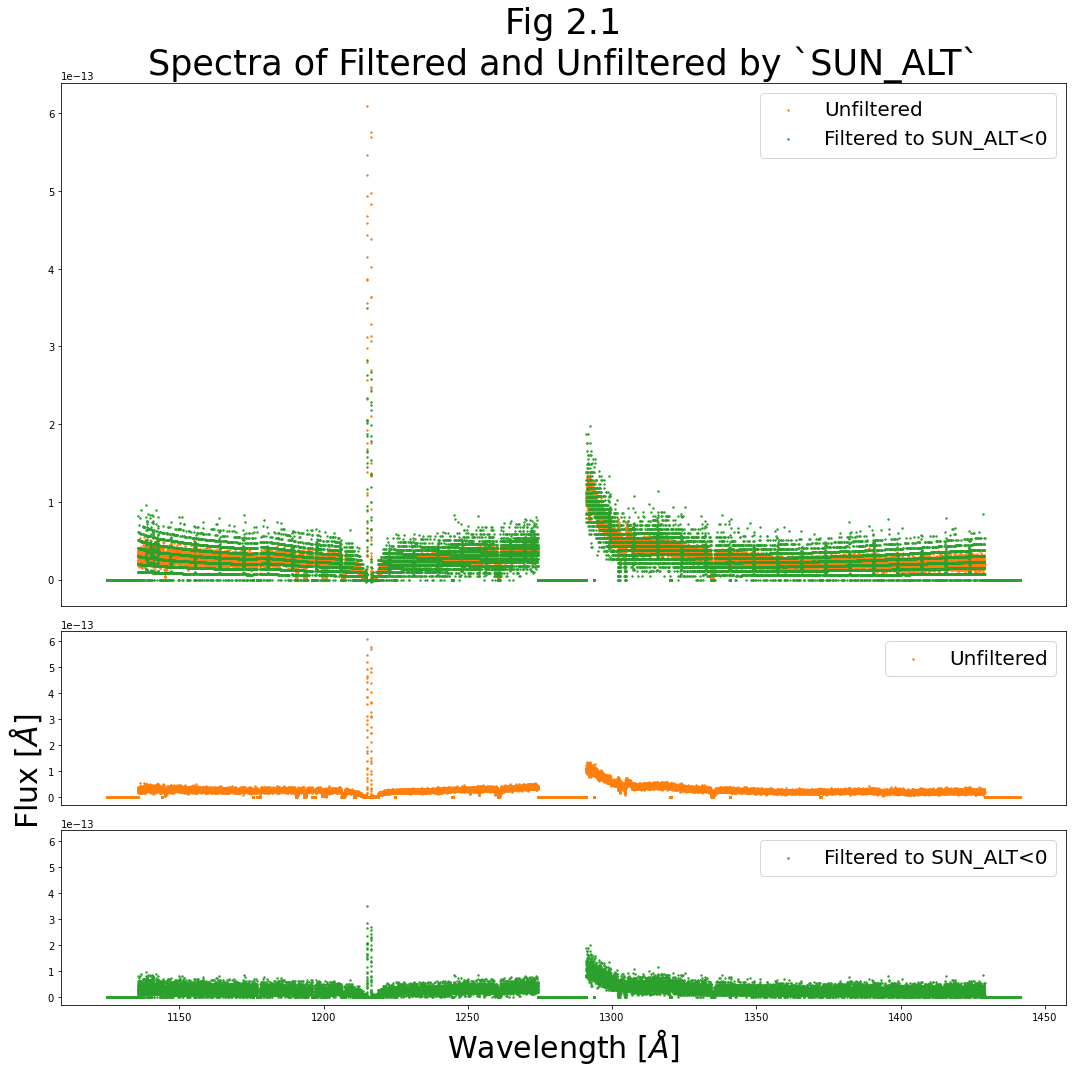

In [140]:
fig = plt.figure(figsize=(15, 15)) 
gs = gridspec.GridSpec(3,1, height_ratios=[3, 1,1]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])


ax0.scatter(combo_dict_u["WAVELENGTH"], combo_dict_u["FLUX"], s = 2, alpha = 1, c = 'C1',label = "Unfiltered")
ax0.scatter(combo_dict_f["WAVELENGTH"], combo_dict_f["FLUX"], s = 2, alpha = 1, c = 'C2', label = "Filtered to SUN_ALT<0")

ax1.scatter(combo_dict_u["WAVELENGTH"], combo_dict_u["FLUX"], s = 2, alpha = 1, c = 'C1',label = "Unfiltered")
ax2.scatter(combo_dict_f["WAVELENGTH"], combo_dict_f["FLUX"], s = 2, alpha = 1, c = 'C2', label = "Filtered to SUN_ALT<0")

# FORMATTING
ax0.set_xticks([])
ax1.set_xticks([])

ax0.legend(fontsize = 20)
ax1.legend(fontsize = 20)
ax2.legend(fontsize = 20)

ax2.set_ylim(ax1.get_ylim())

ax0.set_title("Fig 2.1\nSpectra of Filtered and Unfiltered by `SUN_ALT`", size = 35)
ax1.set_ylabel("Flux [$\AA$]", fontsize = 30, y=0.2, horizontalalignment='center')
ax2.set_xlabel("Wavelength [$\AA$]", fontsize = 30)

plt.tight_layout()

plt.savefig(plots_dir + 'compare_spectra_sunalt.png', dpi = 300)

#### We can see that the filtered spectrum largely follows the unfiltered spectrum; however, we significantly reduce the Lyman-alpha light from airglow around 1215 Å.

Because we filter out many of the datapoints used to calculate the spectrum, we can see a significant reduction in precision in flux space (visible as a **banding** in the y-axis). This can come about because with few datapoints, the bands represent wavelengths which received (0,1,2...n) discrete photons. The banding can sometimes be more pronounced at longer, redder wavelengths. 

#### Below, let's make one final plot: a chunk of the spectrum around \~1215 Å showing the errors in flux:

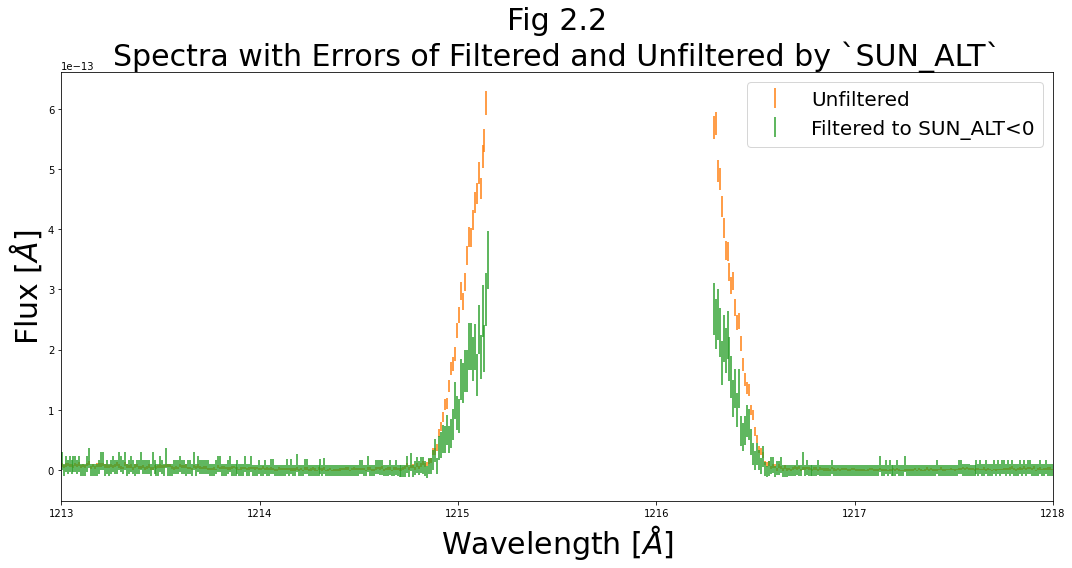

In [142]:
fig, (ax0) = plt.subplots(nrows=1, ncols=1, figsize=(15,8))

ax0.errorbar(combo_dict_u["WAVELENGTH"], combo_dict_u["FLUX"], combo_dict_u["ERROR"], 
             linestyle = '', markersize = 2, alpha = 1, c = 'C1',label = "Unfiltered")
ax0.errorbar(combo_dict_f["WAVELENGTH"], combo_dict_f["FLUX"], combo_dict_f["ERROR"], 
             linestyle = '', markersize = 2, alpha = 1, c = 'C2', label = "Filtered to SUN_ALT<0")

ax0.legend(fontsize = 20)
ax0.set_xlabel("Wavelength [$\AA$]", fontsize = 30)
ax0.set_ylabel("Flux [$\AA$]", fontsize = 30, horizontalalignment='center')
ax0.set_title("Fig 2.2\nSpectra with Errors of Filtered and Unfiltered by `SUN_ALT`", size = 30)
ax0.set_xlim(1213,1218)

plt.tight_layout()
plt.savefig(plots_dir + 'ebar_compare_spectra_sunalt.png', dpi = 300)

With substantially fewer datapoints, our filtered dataset has larger errors. We can, however, understand why we might want to filter by this, or another `sun_alt` filter. For instance, if most of your exposure was taken at night, but the last 10% was taken after the sun had risen and induced an atmospheric line which interferes with your data, it would often be necessary to filter out this last 10% of the exposure.

## Congratulations! You finished this notebook!
### There are more COS data walkthrough notebooks on different topics. You can find them [here](https://github.com/spacetelescope/COS-Notebooks).

---
## About this Notebook
**Author:** Nat Kerman <nkerman@stsci.edu>

**Contributors:** Elaine Mae Frazer

**Updated On:** 2020-11-16

> *This tutorial was generated to be in compliance with the [STScI style guides](https://github.com/spacetelescope/style-guides) and would like to cite the [Jupyter guide](https://github.com/spacetelescope/style-guides/blob/master/templates/example_notebook.ipynb) in particular.*

## Citations

If you use `astropy`, `matplotlib`, `astroquery`, or `numpy` for published research, please cite the
authors. Follow these links for more information about citations:

* [Citing `astropy`/`numpy`/`matplotlib`](https://www.scipy.org/citing.html)
* [Citing `astroquery`](https://astroquery.readthedocs.io/en/latest/)

---

[Top of Page](#topD)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 

<br></br>
<br></br>
<br></br>